In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy.linalg as la

from data import *
from models import train

# Below snippit taken from PyTorch quickstart tutorial
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(device)

cpu


# Data generation functions

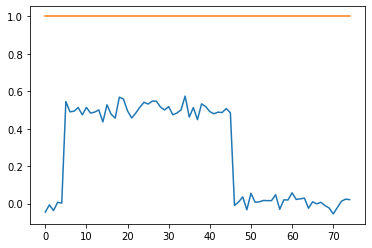

In [3]:
u, y = single_decision(16*3.2/100)
plt.plot(u)
plt.plot(y)

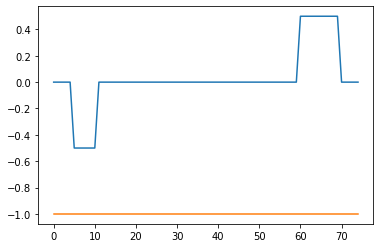

In [4]:
u, y = parametric(10, 34)
plt.plot(u)
plt.plot(y)

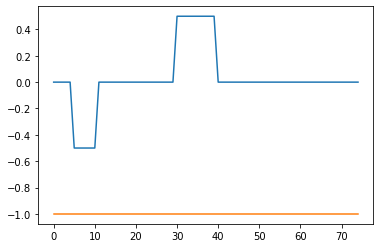

In [5]:
u, y = parametric(10, 34, pause=20)
plt.plot(u)
plt.plot(y)

# RNN Class

In [6]:
class RNN(nn.Module):

    def __init__(self, network_size=128,rank=1):

        super(RNN, self).__init__()
        self.network_size = network_size
        self.rank=rank

        # Weight initialization
        #unit rank rnn weight matrix J=mn^T/n
#         if rank==1:
        self.m = nn.Parameter(torch.Tensor(network_size, rank))
        self.n = nn.Parameter(torch.Tensor(network_size, rank))
        self.wi = torch.Tensor(network_size)
        self.w = torch.Tensor(network_size, 1)
        self.x0= torch.Tensor(network_size, 1)
#         else:
#             self.m = nn.Parameter(torch.Tensor(self.network_size,self.rank))
#             self.n = nn.Parameter(torch.Tensor(self.network_size,self.rank))
#             self.wi = torch.Tensor(self.network_size,1)
#             self.w = torch.Tensor(self.network_size,1)
#             self.x0= torch.Tensor(self.network_size,1)

                # Parameters for weight update formula
        self.tau = 100 #ms
        self.dt = 20 #ms

        # Activation function
        self.activation = nn.Tanh()

        with torch.no_grad():
            self.m.normal_(std=1)
            self.n.normal_(std=1)
            self.w.normal_(std=4)
            self.x0.zero_()
            self.wi.normal_(std=1)

    def forward(self, u, visible_activity=False):
        
        # print(u)
        if len(u.shape) == 1:
            u = u.unsqueeze(0)
            
            
            
        input_len=u.size(1)
        batch_size=u.size(0)
        
        x = torch.zeros(batch_size, self.network_size)
        z = torch.zeros(u.shape)

        r = self.activation(x)

        if visible_activity:
            unit_activity = torch.zeros(batch_size, input_len+1, self.network_size)
            unit_activity[:,0,:] = x

        for i in range(input_len):
            delta_x = (
                -x
                + r.matmul(self.n).matmul(self.m.t()) / self.network_size
                + torch.outer(u[:,i], self.wi.squeeze())
            ) * (self.dt / self.tau)

            x = x + delta_x
            r = self.activation(x)
            if visible_activity:
                unit_activity[:,i+1,:] = x

            output = torch.matmul(r, self.w) / self.network_size
            z[:, i] = output.squeeze()

        if visible_activity:
            return z, unit_activity
        else:
            return z

# Rank-One Tests

In [7]:
sd_single_data = SingleDecisionDataset(1)
train_dataloader = DataLoader(sd_single_data, batch_size=1)
model = RNN()
train(train_dataloader, model, device)

loss: 0.999725  [    1/    1]


In [8]:
sd_single_data = SingleDecisionDataset(5)
train_dataloader = DataLoader(sd_single_data, batch_size=5)
model = RNN()
train(train_dataloader, model, device)

loss: 0.996330  [    5/    5]


In [9]:
sd_dataset = SingleDecisionDataset(8000)
train_dataloader = DataLoader(sd_dataset, batch_size=32)

model = RNN()
train(train_dataloader, model, device)

loss: 0.998385  [   32/ 8000]
loss: 0.043495  [ 3232/ 8000]
loss: 0.000995  [ 6432/ 8000]


torch.Size([75])
(1, 76, 128)


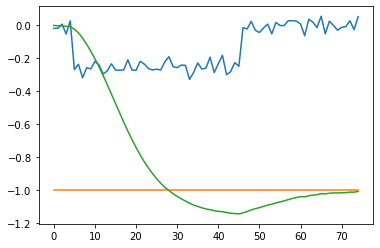

In [10]:
strength = -8
u, y = single_decision(strength*3.2/100)
u, y = torch.Tensor(u), torch.Tensor(y)
print(u.shape)

z = model(u).squeeze().detach().numpy()
plt.plot(u.squeeze())
plt.plot(y.squeeze())
plt.plot(z)

z, u_act = model(u, visible_activity=True)
u_act = u_act.detach().numpy()
print(u_act.shape)


# Full rank single_decision

In [11]:
sd_dataset = SingleDecisionDataset(8000)
train_dataloader = DataLoader(sd_dataset, batch_size=32)

model = RNN(rank=128)
train(train_dataloader, model, device)

loss: 1.061214  [   32/ 8000]
loss: 0.000017  [ 3232/ 8000]
loss: 0.000019  [ 6432/ 8000]


torch.Size([75])
(1, 76, 128)


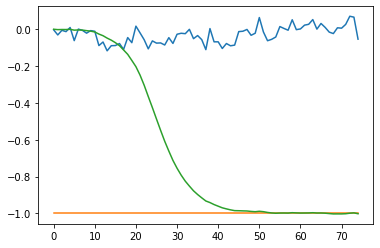

In [12]:
strength = -2
u, y = single_decision(strength*3.2/100)
u, y = torch.Tensor(u), torch.Tensor(y)
print(u.shape)

z = model(u).squeeze().detach().numpy()
plt.plot(u.squeeze())
plt.plot(y.squeeze())
plt.plot(z)

z, u_act = model(u, visible_activity=True)
u_act = u_act.detach().numpy()
print(u_act.shape)

# Rank 2 Parametric

In [13]:
p_data = ParametricDataset(1)
train_dataloader = DataLoader(p_data, batch_size=1)
model = RNN(rank=2)
train(train_dataloader, model, device)


loss: 0.376527  [    1/    1]


In [14]:
p_data = ParametricDataset(5)
train_dataloader = DataLoader(p_data, batch_size=5)
model = RNN(rank=2)
train(train_dataloader, model, device)

loss: 0.112835  [    5/    5]


### Rank 2 network overfits on 1 sample parametric dataset (GOOD!)

In [15]:
p_data = ParametricDataset(1)
train_dataloader = DataLoader(p_data, batch_size=1)
model = RNN(rank=2)

for _ in range(200):
    train(train_dataloader, model, device, T=5)

loss: 0.059505  [    1/    1]
loss: 0.058724  [    1/    1]
loss: 0.057949  [    1/    1]
loss: 0.057179  [    1/    1]
loss: 0.056416  [    1/    1]
loss: 0.055659  [    1/    1]
loss: 0.054907  [    1/    1]
loss: 0.054162  [    1/    1]
loss: 0.053422  [    1/    1]
loss: 0.052688  [    1/    1]
loss: 0.051960  [    1/    1]
loss: 0.051237  [    1/    1]
loss: 0.050521  [    1/    1]
loss: 0.049809  [    1/    1]
loss: 0.049104  [    1/    1]
loss: 0.048404  [    1/    1]
loss: 0.047709  [    1/    1]
loss: 0.047000  [    1/    1]
loss: 0.046268  [    1/    1]
loss: 0.045514  [    1/    1]
loss: 0.044739  [    1/    1]
loss: 0.043943  [    1/    1]
loss: 0.043127  [    1/    1]
loss: 0.042292  [    1/    1]
loss: 0.041439  [    1/    1]
loss: 0.040568  [    1/    1]
loss: 0.039679  [    1/    1]
loss: 0.038775  [    1/    1]
loss: 0.037855  [    1/    1]
loss: 0.036920  [    1/    1]
loss: 0.035972  [    1/    1]
loss: 0.035012  [    1/    1]
loss: 0.034039  [    1/    1]
loss: 0.03

In [21]:
p_data = ParametricDataset(32000)
train_dataloader = DataLoader(p_data, batch_size=32)
model = RNN(rank=2)
train(train_dataloader, model, device, T=5, lr=1e-3)

loss: 0.238379  [   32/32000]
loss: 0.157851  [ 3232/32000]
loss: 0.190081  [ 6432/32000]
loss: 0.134134  [ 9632/32000]
loss: 0.128377  [12832/32000]
loss: 0.133791  [16032/32000]
loss: 0.138438  [19232/32000]
loss: 0.084201  [22432/32000]
loss: 0.113508  [25632/32000]
loss: 0.089511  [28832/32000]


torch.Size([75])
(1, 76, 128)


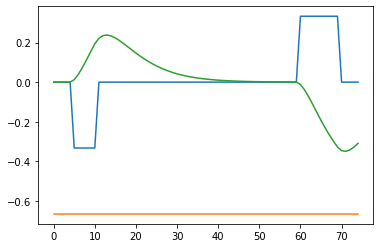

In [17]:
u, y = parametric(14, 30)
u, y = torch.Tensor(u), torch.Tensor(y)
print(u.shape)

z = model(u).squeeze().detach().numpy()
plt.plot(u.squeeze())
plt.plot(y.squeeze())
plt.plot(z)

z, u_act = model(u, visible_activity=True)
u_act = u_act.detach().numpy()
print(u_act.shape)

In [18]:
pause_lengths = np.arange(25, 51, 5)
model = RNN(rank=2)

for pl in pause_lengths:
    p_data = ParametricDataset(6400, pause=pl)
    train_dataloader = DataLoader(p_data, batch_size=32)
    train(train_dataloader, model, device)
    

loss: 0.256695  [   32/ 6400]
loss: 0.131392  [ 3232/ 6400]
loss: 0.137052  [   32/ 6400]
loss: 0.092928  [ 3232/ 6400]
loss: 0.029472  [   32/ 6400]
loss: 0.006640  [ 3232/ 6400]
loss: 0.012841  [   32/ 6400]
loss: 0.004786  [ 3232/ 6400]
loss: 0.020872  [   32/ 6400]
loss: 0.010509  [ 3232/ 6400]
loss: 0.044990  [   32/ 6400]
loss: 0.033155  [ 3232/ 6400]


torch.Size([75])
(1, 76, 128)


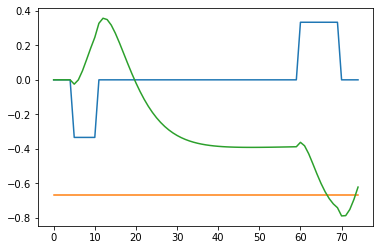

In [19]:
u, y = parametric(14, 30)
u, y = torch.Tensor(u), torch.Tensor(y)
print(u.shape)

z = model(u).squeeze().detach().numpy()
plt.plot(u.squeeze())
plt.plot(y.squeeze())
plt.plot(z)

z, u_act = model(u, visible_activity=True)
u_act = u_act.detach().numpy()
print(u_act.shape)